<a href="https://colab.research.google.com/github/sksoumik/machine-learning-projects/blob/master/Aerial_Cactus_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download image and EDA

In [1]:
from google.colab import files
# upload kaggle.json file to download data using kaggle API 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sadmansoumik","key":"13ae98718981dd5b9e07ae9ed01b5bbe"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
# download the data from kaggle competition 
!kaggle competitions download -c aerial-cactus-identification

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 43.2MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 51.9MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 68.7MB/s]
 68% 13.0M/19.2M [00:00<00:00, 29.3MB/s]
100% 19.2M/19.2M [00:00<00:00, 39.2MB/s]


In [5]:
# unzip train and test folder and remove the zip files 
%%capture 
!unzip test.zip
!unzip train.zip
!rm test.zip
!rm train.zip 

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [7]:
import os

# get current directory 
os.getcwd()

'/content'

In [8]:
# train dataframe

labels = pd.read_csv("/content/train.csv")
labels.head(3) 

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1


In [9]:
train_path = "/content/train/"
test_path = "/content/test/"

In [10]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

```
has_cactus = 1 : has cactus 
has_cactus = 0 : hasn't cactus
```

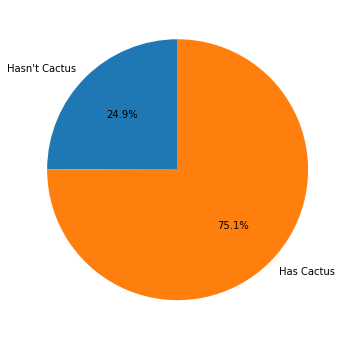

In [11]:
label = 'Hasn\'t Cactus', 'Has Cactus' 
plt.figure(figsize = (6,6))
plt.pie(labels.groupby('has_cactus').size(), labels = label, autopct='%1.1f%%', shadow=False, startangle=90)
plt.show()

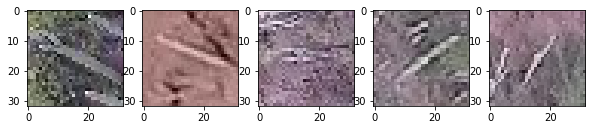

In [12]:
# display 5 images from train data that has cactus 
import matplotlib.image as mpimg

fig, ax = plt.subplots(1,5,figsize = (10,2))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(mpimg.imread(path))

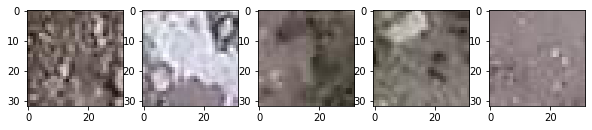

In [13]:
# display 5 images from train data that has no cactus 

fig,ax = plt.subplots(1,5,figsize = (10,2))
for i,idx in enumerate(labels[labels['has_cactus'] == 0]['id'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(mpimg.imread(path))

## Pre-processing

In [14]:
# standardize image by mean and standard deviation 

import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [15]:
import torch.optim as optim 
import torch.utils.data as utils
import torch
import torch.nn as nn
import torch.optim as optim 

import warnings
warnings.filterwarnings("ignore")

## Dataset clss

In [16]:
# class ImageData(Dataset):
#     def __init__(self, df, data_dir, transform):
#         super().__init__()
#         self.df = df
#         self.data_dir = data_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):       
#         img_name = self.df.id[index]
#         label = self.df.has_cactus[index]
        
#         img_path = os.path.join(self.data_dir, img_name)
#         image = mpimg.imread(img_path)
#         image = self.transform(image)
#         return image, label

class CactusDataset(Dataset):
    def __init__(self, df, path, transform = None):
        super().__init__()
        self.df = df.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.path, img_name)
        image = mpimg.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [17]:
# data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
# train_data = ImageData(df = labels, data_dir = train_path, transform = data_transf)
# train_loader = DataLoader(dataset = train_data, batch_size = 64, shuffle=True) 

## Transforms

In [18]:
means, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std)])

In [19]:
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

In [20]:
valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

## Split the dataset

In [21]:
# split the train data into train and validation set 

train_df, valid_df = train_test_split(labels, 
                                     stratify=labels.has_cactus, 
                                     test_size=0.2)

In [22]:
train_df.head(2)

,id,has_cactus
14876,d8bbaa363027f93a34c7782a8f309ec8.jpg,1
1147,107b916b3eefd665c925d0a56b4cf7e7.jpg,1


In [23]:
train_df, test_df = train_test_split(train_df, 
                                     stratify=train_df.has_cactus, 
                                     test_size=0.2)

In [24]:
len(train_df), len(valid_df), len(test_df) 

(11200, 3500, 2800)

In [25]:
# train data 
train_data = CactusDataset(train_df, train_path, train_transform)

In [26]:
# validation data 
valid_data = CactusDataset(valid_df, train_path, transform=valid_transform)

In [27]:
# test data 
test_data = CactusDataset(test_df, train_path, transform=test_transform)

## Hyperparameters

In [28]:
# define hyperparameters 

num_epochs = 15
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [29]:
# data loaders

train_loader = DataLoader(dataset=train_data, 
                          batch_size = batch_size, 
                          shuffle=True, 
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_data, 
                          batch_size = batch_size, 
                          shuffle=False, 
                          num_workers=0)

test_loader = DataLoader(dataset=test_data, 
                         batch_size = batch_size, 
                         shuffle=False, 
                         num_workers=0)

## Custom CNN Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [33]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [34]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.209069 	Validation Loss: 0.079070
Epoch: 2 	Training Loss: 0.106642 	Validation Loss: 0.058605
Epoch: 3 	Training Loss: 0.095184 	Validation Loss: 0.063400
Epoch: 4 	Training Loss: 0.078689 	Validation Loss: 0.056614
Epoch: 5 	Training Loss: 0.072361 	Validation Loss: 0.054775
Epoch: 6 	Training Loss: 0.071070 	Validation Loss: 0.053702
Epoch: 7 	Training Loss: 0.059541 	Validation Loss: 0.051485
Epoch: 8 	Training Loss: 0.060267 	Validation Loss: 0.045912
Epoch: 9 	Training Loss: 0.061541 	Validation Loss: 0.039526
Epoch: 10 	Training Loss: 0.059396 	Validation Loss: 0.054103
Epoch: 11 	Training Loss: 0.053523 	Validation Loss: 0.040252
Epoch: 12 	Training Loss: 0.052536 	Validation Loss: 0.043402
Epoch: 13 	Training Loss: 0.054019 	Validation Loss: 0.046389
Epoch: 14 	Training Loss: 0.049426 	Validation Loss: 0.041892
Epoch: 15 	Training Loss: 0.045210 	Validation Loss: 0.037367
CPU times: user 1min 57s, sys: 5.08 s, total: 2min 2s
Wall time: 2min 3s


In [35]:
# test-the-model

model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
# Save the model 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 98.60714285714286 %


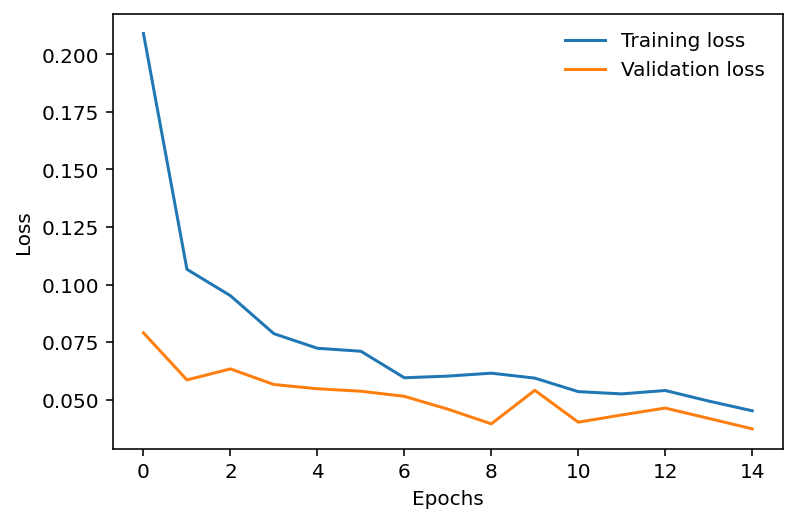

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

## Transfer Learning (EfficientNet)

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv("/content/train.csv")

In [ ]:
train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
train_path = "/content/train/"

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train_data,
                                    stratify=train_data['has_cactus'], 
                                    test_size=0.20)

In [ ]:
train_df.reset_index(inplace = True)

In [ ]:
test_df.reset_index(inplace = True) 

In [ ]:
test_df.head()

,index,id,has_cactus
0,283,043d6f04479edc752dfdf5d62af43491.jpg,1
1,4283,3c67539419c47afa1d99ce9bb21352e6.jpg,1
2,17012,f8c0b24fa0490b66c81770b45e8bc9ef.jpg,1
3,539,07ee453070fd57ded2f718b58602b86a.jpg,1
4,502,0754c6e64a4286570f907d7916a15fe3.jpg,1


In [ ]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.id[index]
        label = self.df.has_cactus[index]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = mpimg.imread(img_path)
        image = self.transform(image)
        return image, label

In [ ]:
len(train_df)

14000

In [ ]:
data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

train_data = ImageData(df = train_df, data_dir = train_path, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size = 64)

In [ ]:
test_data = ImageData(df = test_df, data_dir = train_path, transform = data_transf)
test_loader = DataLoader(dataset = test_data, shuffle=False) 

In [ ]:
!pip install efficientnet_pytorch

## EfficientNet

In [ ]:
from efficientnet_pytorch import EfficientNet
model_eff = EfficientNet.from_name('efficientnet-b1')

In [ ]:
# Unfreeze model weights
for param in model_eff.parameters():
    param.requires_grad = True

In [ ]:
num_ftrs = model_eff._fc.in_features
model_eff._fc = nn.Linear(num_ftrs, 1)

In [ ]:
model_eff = model_eff.to('cuda')

In [ ]:
optimizer = optim.Adam(model_eff.parameters())
loss_func = nn.BCELoss()

In [ ]:
%%time
# Train model
loss_log = []

for epoch in range(5):    
    model_eff.train()    
    for ii, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()                

        optimizer.zero_grad()
        output = model_eff(data)                
    
        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()  
        
        if ii % 1000 == 0:
            loss_log.append(loss.item())
       
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 - Loss: 0.541067
Epoch: 2 - Loss: 0.554949
Epoch: 3 - Loss: 0.544592
Epoch: 4 - Loss: 0.529942
Epoch: 5 - Loss: 0.529917
CPU times: user 2min 9s, sys: 1.54 s, total: 2min 10s
Wall time: 2min 11s


In [ ]:
%%time
predict = []
model_eff.eval()
for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model_eff(data)    

    pred = torch.sigmoid(output)
    predicted_vals = pred > 0.5
    predict.append(int(predicted_vals))
    
test_df['prediction'] = predict

CPU times: user 1min 10s, sys: 143 ms, total: 1min 10s
Wall time: 1min 10s


In [ ]:
test_df['prediction'].value_counts()

1    3500
Name: prediction, dtype: int64